In [1]:
import numpy as np
import time
import cv2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = 8, 6

In [3]:
x_train = np.load('./data/x_train.npy')
y_train = np.load('./data/y_train.npy')
x_test = np.load('./data/x_test.npy')
y_test = np.load('./data/y_test.npy')
x_val = np.load('./data/x_val.npy')
y_val = np.load('./data/y_val.npy')

x = np.vstack((x_train, x_test))
y = np.concatenate((y_train, y_test))

In [4]:
from lbp import LBP

start = time.time()

lbp = LBP(500, 8)

features = []

for img in x:
    features.append(lbp.compute(img))

features = np.array(features)
print(f'Time => {time.time() - start}')

Time => 884.3397173881531


In [5]:
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
print('Train shape: ', x_train.shape, y_train.shape)
print('Test shape: ', x_test.shape, y_test.shape)

Train shape:  (4672, 502) (4672,)
Test shape:  (1168, 502) (1168,)


In [6]:
start = time.time()

model = SVC(kernel='linear', probability=True) 
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Validation accuracy: ', accuracy_score(y_test, y_test_pred))
print(f'Training time {time.time() - start}')

Train accuracy:  0.7326626712328768
Validation accuracy:  0.7208904109589042
Training time 57.258060693740845


In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  0 326]
 [  0 842]]


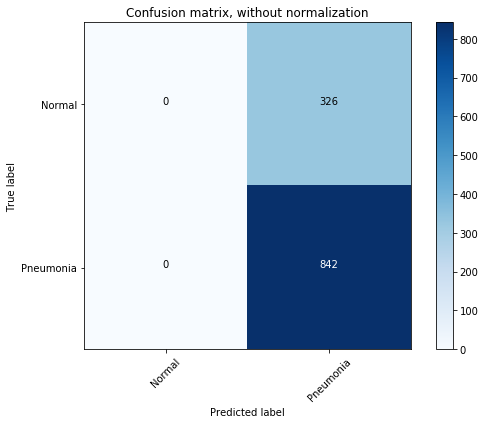

In [8]:
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pneumonia'],
                      title='Confusion matrix, without normalization')

Na cm plotu se vidi da SVM model nije validan, za svaki ulaz se dobija ista predikcija.

In [10]:
start = time.time()

from xgboost import XGBClassifier
model = XGBClassifier(max_depth=1000, objective='binary:logistic', seed=42) 
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Validation accuracy: ', accuracy_score(y_test, y_test_pred))
print(f'Training time {time.time() - start}')

Train accuracy:  1.0
Validation accuracy:  0.8690068493150684
Training time 25.610103845596313


In [11]:
real = []
pred = []
for img, label in zip(x_val, y_val):
    feature_vector = lbp.compute(img)
    prediction = model.predict(feature_vector.reshape(1, -1))[0]
    real.append(label)
    pred.append(prediction)
    print(f'Real label: {label} ==> Predicted lables: {prediction}')

Real label: 0 ==> Predicted lables: 1
Real label: 0 ==> Predicted lables: 1
Real label: 0 ==> Predicted lables: 1
Real label: 0 ==> Predicted lables: 1
Real label: 0 ==> Predicted lables: 1
Real label: 0 ==> Predicted lables: 1
Real label: 0 ==> Predicted lables: 0
Real label: 0 ==> Predicted lables: 1
Real label: 1 ==> Predicted lables: 1
Real label: 1 ==> Predicted lables: 0
Real label: 1 ==> Predicted lables: 1
Real label: 1 ==> Predicted lables: 1
Real label: 1 ==> Predicted lables: 1
Real label: 1 ==> Predicted lables: 1
Real label: 1 ==> Predicted lables: 1
Real label: 1 ==> Predicted lables: 1


Confusion matrix, without normalization
[[229  97]
 [ 56 786]]


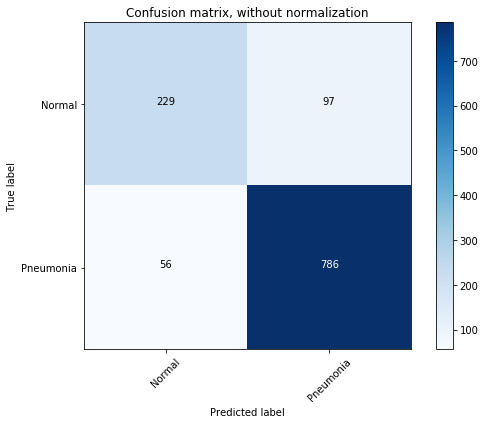

In [13]:
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pneumonia'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.7  0.3 ]
 [0.07 0.93]]


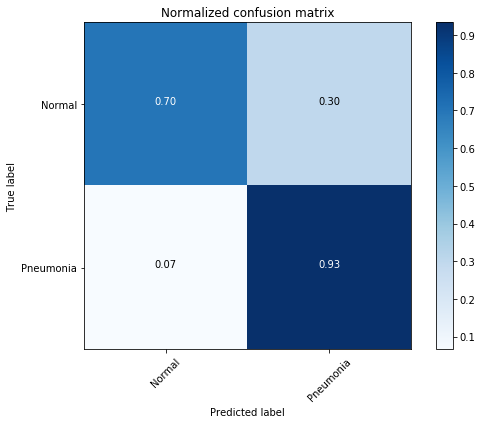

In [14]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pneumonia'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [15]:
tn, fp, fn, tp = cnf_matrix.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1_score))

Accuracy of the model is 0.87
Recall of the model is 0.93
Precision of the model is 0.89
F1 Score of the model is 0.91


Na cm plotovima se vidi da je Gradient Boosting klasifikator mnogo bolji od SVM klasifikatora.
Na osnovu ovih rezultata i rezultata iz notebooka 2.HOG+SVM,
zakljucuje se da je konkretno u ovom slucaju HOG deskriptor bolji za feature extraction.
Pored ova dva algoritma, vredi pokusati i MLP neuronsku mrezu.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def get_mlp(input_dim, dropout=False):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_dim,), activation='relu'))
    if dropout:
        model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    if dropout:
        model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model
    
def nn_plots(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Using TensorFlow backend.


In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='best_mlp.h5', monitor='val_loss', save_best_only=True)]

model = get_mlp(x_test.shape[1])
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=callbacks, validation_data=(x_test, y_test))

Train on 4672 samples, validate on 1168 samples
Epoch 1/100
4672/4672 [==============================] - 4s 777us/step - loss: 0.5951 - acc: 0.7250 - val_loss: 0.5838 - val_acc: 0.7209
Epoch 2/100
4672/4672 [==============================] - 2s 425us/step - loss: 0.5306 - acc: 0.7327 - val_loss: 0.4709 - val_acc: 0.7209
Epoch 3/100
4672/4672 [==============================] - 2s 419us/step - loss: 0.4364 - acc: 0.7697 - val_loss: 0.4007 - val_acc: 0.8091
Epoch 4/100
4672/4672 [==============================] - 3s 580us/step - loss: 0.3940 - acc: 0.8048 - val_loss: 0.3891 - val_acc: 0.8185
Epoch 5/100
4672/4672 [==============================] - 2s 421us/step - loss: 0.3771 - acc: 0.8131 - val_loss: 0.3686 - val_acc: 0.8356
Epoch 6/100
4672/4672 [==============================] - 2s 511us/step - loss: 0.3700 - acc: 0.8226 - val_loss: 0.3603 - val_acc: 0.8296
Epoch 7/100
4672/4672 [==============================] - 2s 511us/step - loss: 0.3613 - acc: 0.8266 - val_loss: 0.3532 - val_acc: 

4672/4672 [==============================] - 3s 565us/step - loss: 0.2463 - acc: 0.8934 - val_loss: 0.2920 - val_acc: 0.8707
Epoch 61/100
4672/4672 [==============================] - 2s 424us/step - loss: 0.2434 - acc: 0.8981 - val_loss: 0.2858 - val_acc: 0.8759
Epoch 62/100
4672/4672 [==============================] - 2s 394us/step - loss: 0.2519 - acc: 0.8921 - val_loss: 0.2858 - val_acc: 0.8673
Epoch 63/100
4672/4672 [==============================] - 2s 328us/step - loss: 0.2496 - acc: 0.8938 - val_loss: 0.2820 - val_acc: 0.8724
Epoch 64/100
4672/4672 [==============================] - 2s 437us/step - loss: 0.2477 - acc: 0.8923 - val_loss: 0.3013 - val_acc: 0.8656
Epoch 65/100
4672/4672 [==============================] - 2s 376us/step - loss: 0.2535 - acc: 0.8930 - val_loss: 0.2959 - val_acc: 0.8690


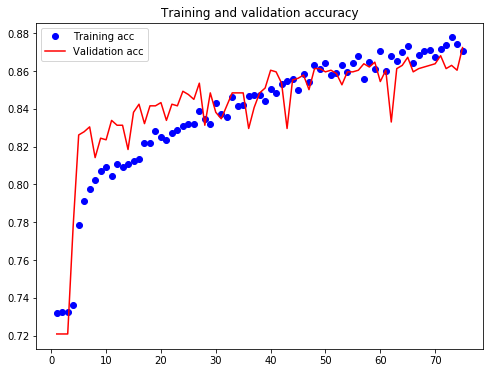

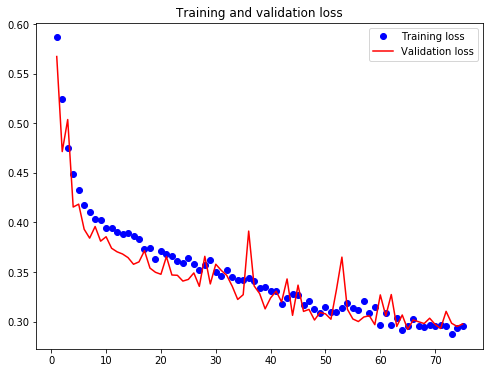

In [32]:
nn_plots(history)

In [33]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='best_mlp_dropout.h5', monitor='val_loss', save_best_only=True)]

model_dropout = get_mlp(x_test.shape[1], dropout=True)
history = model_dropout.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=callbacks, validation_data=(x_test, y_test))

Train on 4672 samples, validate on 1168 samples
Epoch 1/100
4672/4672 [==============================] - 5s 1ms/step - loss: 0.5883 - acc: 0.7327 - val_loss: 0.5683 - val_acc: 0.7209
Epoch 2/100
4672/4672 [==============================] - 3s 547us/step - loss: 0.5222 - acc: 0.7327 - val_loss: 0.4689 - val_acc: 0.7209
Epoch 3/100
4672/4672 [==============================] - 2s 434us/step - loss: 0.4809 - acc: 0.7327 - val_loss: 0.4595 - val_acc: 0.7209
Epoch 4/100
4672/4672 [==============================] - 2s 464us/step - loss: 0.4690 - acc: 0.7327 - val_loss: 0.4499 - val_acc: 0.7209
Epoch 5/100
4672/4672 [==============================] - 2s 531us/step - loss: 0.4632 - acc: 0.7327 - val_loss: 0.4424 - val_acc: 0.7209
Epoch 6/100
4672/4672 [==============================] - 3s 561us/step - loss: 0.4482 - acc: 0.7327 - val_loss: 0.4133 - val_acc: 0.7235
Epoch 7/100
4672/4672 [==============================] - 3s 606us/step - loss: 0.4147 - acc: 0.7795 - val_loss: 0.3892 - val_acc: 0.

4672/4672 [==============================] - 2s 365us/step - loss: 0.2896 - acc: 0.8748 - val_loss: 0.3334 - val_acc: 0.8622
Epoch 61/100
4672/4672 [==============================] - 2s 351us/step - loss: 0.2968 - acc: 0.8684 - val_loss: 0.3255 - val_acc: 0.8622
Epoch 62/100
4672/4672 [==============================] - 2s 388us/step - loss: 0.3037 - acc: 0.8746 - val_loss: 0.3007 - val_acc: 0.8664


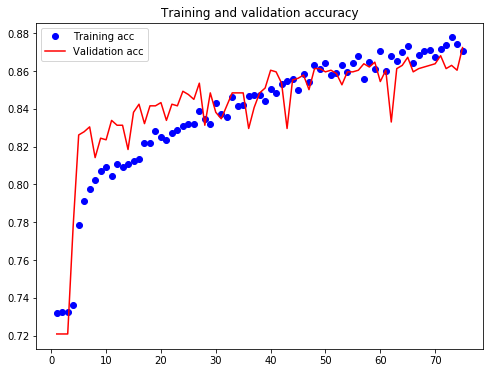

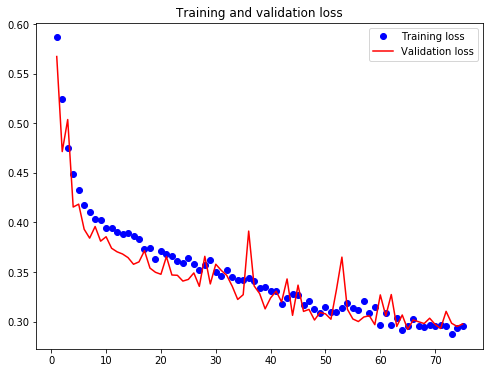

In [31]:
nn_plots(history)

#### Evaluacija MLP modela sa sledecom arhitekturom:

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               128768    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 172,545
Trainable params: 172,545
Non-trainable params: 0
_________________________________________________________________


In [34]:
x_test = np.load('./data/x_test.npy')
y_test = np.load('./data/y_test.npy')

In [35]:
y_test_pred = []
for img in x_test:
    feature_vector = lbp.compute(img)
    prediction = model.predict_classes(feature_vector.reshape(1, -1))
    y_test_pred.append(prediction)

In [36]:
y_tp = []
for i in range(len(y_test_pred)):
    y_tp.append(y_test_pred[i][0][0])

Confusion matrix, without normalization
[[126 108]
 [  9 381]]


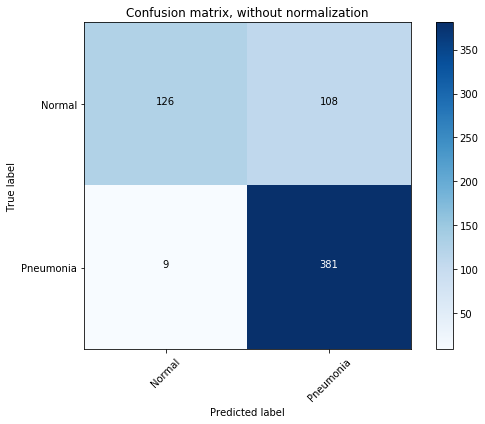

In [37]:
cnf_matrix = confusion_matrix(y_test, y_tp)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pneumonia'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.54 0.46]
 [0.02 0.98]]


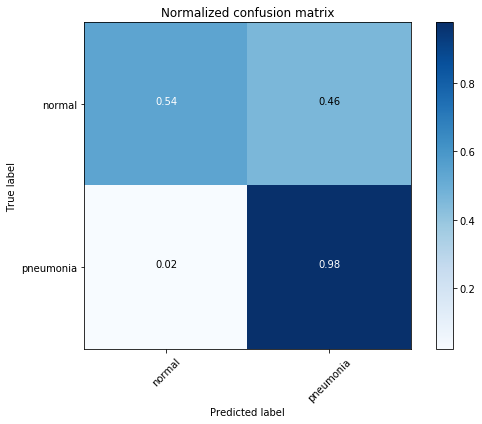

In [38]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['normal', 'pneumonia'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

MLP pogresno klasifikuje skoro pola normalnih snimaka, dok snimke na kojima je prisutna pneumonia klasifikuje bolje od predhodnih modela.

In [47]:
tn, fp, fn, tp = cnf_matrix.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*((precision*recall)/(precision+recall))
accuracy = (tp+tn) / (tp+tn+fp+fn)

print("Accuracy of the model is {:.2f}".format((accuracy)))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1_score))

Accuracy of the model is 0.81
Recall of the model is 0.98
Precision of the model is 0.78
F1 Score of the model is 0.87


#### Evaluacija MLP modela sa sledecom arhitekturom:

In [49]:
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               128768    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
__________

In [51]:
x_test = np.load('./data/x_test.npy')
y_test = np.load('./data/y_test.npy')

y_test_pred = []
for img in x_test:
    feature_vector = lbp.compute(img)
    prediction = model_dropout.predict_classes(feature_vector.reshape(1, -1))
    y_test_pred.append(prediction)
    
y_tp = []
for i in range(len(y_test_pred)):
    y_tp.append(y_test_pred[i][0][0])

Confusion matrix, without normalization
[[ 97 137]
 [ 13 377]]


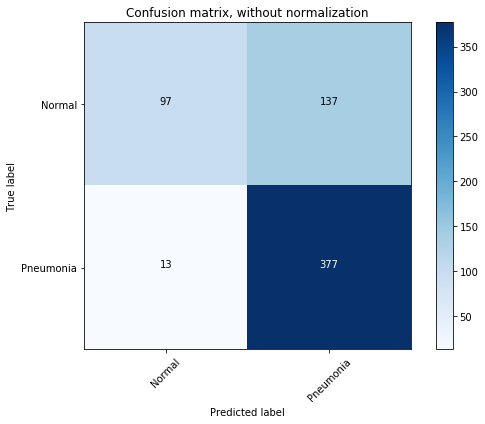

In [52]:
cnf_matrix = confusion_matrix(y_test, y_tp)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Pneumonia'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.41 0.59]
 [0.03 0.97]]


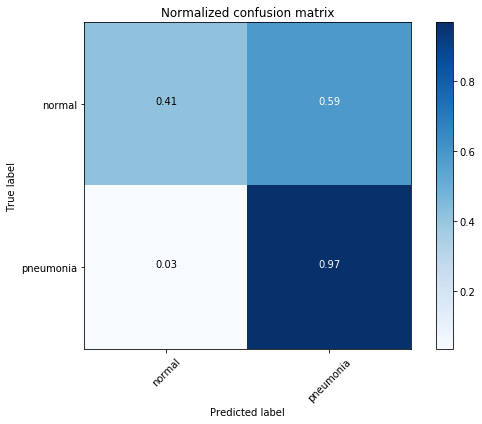

In [53]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['normal', 'pneumonia'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [54]:
tn, fp, fn, tp = cnf_matrix.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*((precision*recall)/(precision+recall))
accuracy = (tp+tn) / (tp+tn+fp+fn)

print("Accuracy of the model is {:.2f}".format((accuracy)))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1_score))

Accuracy of the model is 0.76
Recall of the model is 0.97
Precision of the model is 0.73
F1 Score of the model is 0.83


Na osnovu cm vidi se da ova neurosnka mreze manje precizna od prethonog modela.